<a href="https://colab.research.google.com/github/MAvRK7/Neural-Nets-Learning/blob/main/Makemore2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting names using MLP

We go here because, the N matrix from Makemore is not scalable

Bengio et al.

So in this paper, they are working on word prediction. Initially they start with a 30 Dim space and have 17,000 words spaced out randomly in this space. Slowly, by backprop, they start to align related words to each other (synonyms in the similar part of the space)

eg: The dog was running in a ___ has never appeared in the training (we are OUT OF DISTRIBUTION)

what the model does it, wait ive seen a similar word, a cat was running in a room, dogs and cats are similar in this context (emb for cat and emb for dog are similar)  and so we can put "running" in the dash

transfer knowledge through embedding space

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words= open("/content/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
#build vocabulary and map, from words (as char) to string and vice versa
chars=sorted(list(set("".join(words))))# a b c...z
stoi= {s:i+1 for i,s in enumerate(chars)}
stoi["."]=0
itos= {i:s for s,i in stoi.items()} #dont forget .items()
print(f"{itos=}")
print(f"{stoi=}")

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [ ]:
#build the dataset

block_size=3 #context length, consider last 3 digits to predict the 4th one
X, Y= [], [] # X is the current running context; Y is the current char
for w in words[:5]:

  print(w)
  context= [0]*block_size #so context becomes [0, 0, 0]
  for ch in w + ".": #emma. olivia.
    ix= stoi[ch] #ix is the index value of the ch

    X.append(context) # X: [[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [0, 0, 0]]...

    Y.append(ix) # Y: [5, 13, 13, 1, 0, 15]...
    print("".join(itos[i] for i in context), "--->", itos[ix])
    context= context[1:] + [ix] #crop and append
    #Drops the first (oldest) character → context[1:] then, Appends the new character index ix

X= torch.tensor(X)
Y= torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


so now, from these 5 words, the dataset looks like so:

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

We have 32 egs, each input to the NN is 3 integers and we have a label that is also an int Y

In [ ]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

Y is labels

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

We build a NN that takes these X and predicts Y

eg: should take [0,0,0] and predict 5, and so on

But first we need to build the embedding lookup table C

so we have 27 possible characters,  and we're going to embed them in a lower dimesional space

In the paper, they have 17k words, which they embed in a 30 dim space

So, we can cram our 27 chars into as small as a 2D space

In [ ]:
C= torch.randn([27,2])

#eg C[0] → "a"  = [ 0.2, -0.5]; 2 things

Now, we can either index this matrix

In [ ]:
C[5]

tensor([0.4880, 0.4474])

Or we can do one hot encoding, and then matrix multiply with C, we get the same thing, so lets do the simple way

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C #5 has to be a torch.tensor, and make it float

tensor([0.4880, 0.4474])

so we can either think of this first step, embedding of the int  as
1. an integer indexing into the lookup table C
2. First layer of this bigger nn (without act, linear and their weight matrix is C). We are encoding into one hot and feeding the neurons into the system

both are EQUIVALENT, lets do option 1 for simplicity



Now, embedding a single integer like 5 is easy, just C[5] row index

But X's shape is torch.Size([32, 3]), how do we simultaneously embed this?

In [ ]:
#pytorch embedding is flexible
#we can index using lists
print("using lists\n")
print(C[[5,6,7]]) #get me C's 5th, 6th and 7th rows
#can be a tensor also
print("----")
print("using tensor\n")
print(C[torch.tensor([5,6,7,7,7])]) #indexing with 1D tensors, get me C's 5th, 6th and (7th row thrice)
#7 can be repeated also


using lists

tensor([[ 0.4880,  0.4474],
        [ 0.0967,  0.1328],
        [-0.4162,  2.0559]])
----
using tensor

tensor([[ 0.4880,  0.4474],
        [ 0.0967,  0.1328],
        [-0.4162,  2.0559],
        [-0.4162,  2.0559],
        [-0.4162,  2.0559]])


In [ ]:
# C[X] means For each of these (0,0,5 and all) indices, go look up the corresponding row in C.

In [ ]:
'''
C[[0, 0, 5]]
 = [
    C[0],   # embedding for '.' → which consists of 2 numbers, eg [ 0.2, -0.5]
    C[0],   # embedding for '.' → 2 nos
    C[5],   # embedding for 'e' → 2 nos
  ]
'''


"\nC[[0, 0, 5]]\n = [\n    C[0],   # embedding for '.' → which consists of 2 numbers, eg [ 0.2, -0.5]\n    C[0],   # embedding for '.' → 2\n    C[5],   # embedding for 'e' → 2\n  ]\n"

In [ ]:
#we can index using 2D tensors also, eg X is [32,3]
C[X].shape
#for every one of that 32,3 we have retireved an embedding vector

torch.Size([32, 3, 2])

In [ ]:
#for example, in 13,2 there an integer
X[13,2]

tensor(1)

In [ ]:
#to get its embedding:
C[X][13,2]

tensor([ 0.6274, -0.6428])

So, the tensor 1 will be passed as the above output to the model

In [ ]:
#verification
C[1]

tensor([ 0.6274, -0.6428])

To embed all of the integers in X simultaneously, we just do C[X]

In [ ]:
C[X]

tensor([[[ 0.1138, -1.1450],
         [ 0.1138, -1.1450],
         [ 0.1138, -1.1450]],

        [[ 0.1138, -1.1450],
         [ 0.1138, -1.1450],
         [ 0.4880,  0.4474]],

        [[ 0.1138, -1.1450],
         [ 0.4880,  0.4474],
         [-1.1649, -0.0261]],

        [[ 0.4880,  0.4474],
         [-1.1649, -0.0261],
         [-1.1649, -0.0261]],

        [[-1.1649, -0.0261],
         [-1.1649, -0.0261],
         [ 0.6274, -0.6428]],

        [[ 0.1138, -1.1450],
         [ 0.1138, -1.1450],
         [ 0.1138, -1.1450]],

        [[ 0.1138, -1.1450],
         [ 0.1138, -1.1450],
         [-0.7930, -2.1206]],

        [[ 0.1138, -1.1450],
         [-0.7930, -2.1206],
         [-0.4840, -0.6635]],

        [[-0.7930, -2.1206],
         [-0.4840, -0.6635],
         [-1.2364,  1.5506]],

        [[-0.4840, -0.6635],
         [-1.2364,  1.5506],
         [ 0.6669,  0.0167]],

        [[-1.2364,  1.5506],
         [ 0.6669,  0.0167],
         [-1.2364,  1.5506]],

        [[ 0.6669,  0

In [ ]:
emb= C[X]
emb.shape

torch.Size([32, 3, 2])

* 32 → number of examples in your mini-batch
* 3 → number of characters in the context (block size = 3)
* 2 → number of features (embedding dimensions) per character

example

... (which is represented as 0,0,0 in X that should give o/p e or 5) is embedded as

[-0.4761, -0.9558],
         [-0.4761, -0.9558],
         [-0.4761, -0.9558],

In [ ]:
W1= torch.randn((6,100))#why 6?
b1 = torch.randn(100)

for each example, the network has:

3 characters × 2 numbers per character = 6 total numbers (as inputs)

context = [., e, m]

* .  → [ 0.1, -0.5]
* e  → [-0.4,  1.0]
* m  → [ 0.8,  0.3]

[ 0.1, -0.5, -0.4, 1.0, 0.8, 0.3 ]

6 inputs

now, lets say we have 100 neurons in this layer

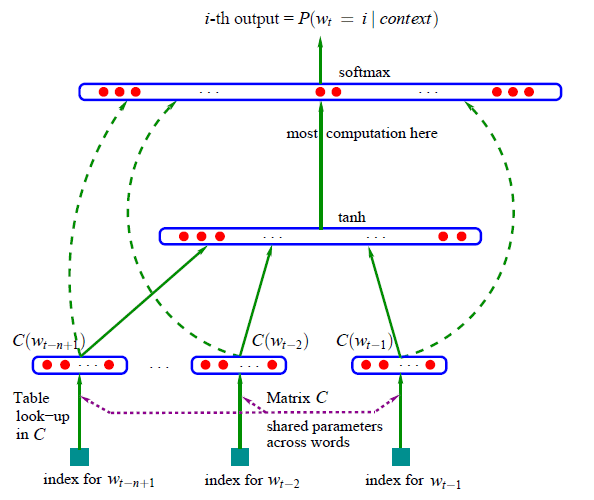

Now, normally we would do

emb@ W1 + b

but here, this will not work as C[X] is of shape 32,3,2 and we cant multiply that with 6,100

to be able to multiply we need to change 32,3,2 into 32,6

Now, we can take 32,3,2 and cocatinate the last two and make it 32,6

basically go from

[

  [a1, a2],   # embedding for 1st char in context

  [b1, b2],   # embedding for 2nd char

  [c1, c2]    # embedding for 3rd char

]

to

[a1, a2, b1, b2, c1, c2]


In [ ]:
#1. by using torch.cat
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([32, 6])

In [ ]:
#explanation:
'''
if emb was 2,3,2 instead of emb.shape = [32, 3, 2]
emb = [
  [ [a11, a12],   [a21, a22],   [a31, a32] ],   # example 1
  [ [b11, b12],   [b21, b22],   [b31, b32] ]    # example 2
]

emb[:, 0, :] =
[
  [a11, a12],   # from example 1
  [b11, b12]    # from example 2
]

emb[:, 1, :] =
[
  [a21, a22],
  [b21, b22]
]

emb[:, 2, :] =
[
  [a31, a32],
  [b31, b32]
]

finally we say 1, as in along ---

torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1)
=
[
  [a11, a12, a21, a22, a31, a32],
  [b11, b12, b21, b22, b31, b32]
]

'''


'\nif emb was 2,3,2 instead of emb.shape = [32, 3, 2]\nemb = [\n  [ [a11, a12],   [a21, a22],   [a31, a32] ],   # example 1\n  [ [b11, b12],   [b21, b22],   [b31, b32] ]    # example 2\n]\n\nemb[:, 0, :] =\n[\n  [a11, a12],   # from example 1\n  [b11, b12]    # from example 2\n]\n\nemb[:, 1, :] =\n[\n  [a21, a22],\n  [b21, b22]\n]\n\nemb[:, 2, :] =\n[\n  [a31, a32],\n  [b31, b32]\n]\n\nfinally we say 1, as in along ---\n\ntorch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1)\n=\n[\n  [a11, a12, a21, a22, a31, a32],\n  [b11, b12, b21, b22, b31, b32]\n]\n\n'

But this code is not generalizable, because we if take more than 3 inputs, this code has to change

In [ ]:
#2. using torch.unbind
torch.cat(torch.unbind(emb, dim=1), dim=1).shape
#very ineficient

torch.Size([32, 6])

In [ ]:
#explanation

'''
torch.unbind removed a dimension

input:
torch.unbind(torch.tensor([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]]))
output:
(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))

so,
context 1   context 2   context 3
[• •]  →  [• •]  →  [• •]

becomes on applying torch.unbind along dim 1

→ [• •], [• •], [• •]

which upon cat becomes

[• • | • • | • •]  → now shape [batch, 6]
'''

'\ntorch.unbind removed a dimension\n\ninput:\ntorch.unbind(torch.tensor([[1, 2, 3],\n                           [4, 5, 6],\n                           [7, 8, 9]]))\noutput:\n(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))\n\nso, \ncontext 1   context 2   context 3\n[• •]  →  [• •]  →  [• •]\n\nbecomes on applying torch.unbind along dim 1\n\n→ [• •], [• •], [• •]\n\nwhich upon cat becomes\n\n[• • | • • | • •]  → now shape [batch, 6]\n'

In [ ]:
#turns out in this case, asignificantly better and more efficient way

In [ ]:
#torch.view()
#we have
a= torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.shape

torch.Size([18])

In [ ]:
#we can view a in different ways
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [ ]:
a.view(3,2,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

we can view it in any way as long as whats inside () multiply to 18 (original size)

In [ ]:
# view in tourch is ext efficient as every tensor has a storeage as no memory is being copied or moved
a.storage()

/tmp/ipython-input-1661380985.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [ ]:
#coming back to emb
#3. by using emb.view NOT torch.view() no []
emb.view(32, 3 * 2)

tensor([[ 0.1138, -1.1450,  0.1138, -1.1450,  0.1138, -1.1450],
        [ 0.1138, -1.1450,  0.1138, -1.1450,  0.4880,  0.4474],
        [ 0.1138, -1.1450,  0.4880,  0.4474, -1.1649, -0.0261],
        [ 0.4880,  0.4474, -1.1649, -0.0261, -1.1649, -0.0261],
        [-1.1649, -0.0261, -1.1649, -0.0261,  0.6274, -0.6428],
        [ 0.1138, -1.1450,  0.1138, -1.1450,  0.1138, -1.1450],
        [ 0.1138, -1.1450,  0.1138, -1.1450, -0.7930, -2.1206],
        [ 0.1138, -1.1450, -0.7930, -2.1206, -0.4840, -0.6635],
        [-0.7930, -2.1206, -0.4840, -0.6635, -1.2364,  1.5506],
        [-0.4840, -0.6635, -1.2364,  1.5506,  0.6669,  0.0167],
        [-1.2364,  1.5506,  0.6669,  0.0167, -1.2364,  1.5506],
        [ 0.6669,  0.0167, -1.2364,  1.5506,  0.6274, -0.6428],
        [ 0.1138, -1.1450,  0.1138, -1.1450,  0.1138, -1.1450],
        [ 0.1138, -1.1450,  0.1138, -1.1450,  0.6274, -0.6428],
        [ 0.1138, -1.1450,  0.6274, -0.6428,  0.6669,  0.0167],
        [ 0.6274, -0.6428,  0.6669,  0.0

In [ ]:
#so if we use view, this works
h= emb.view(32, 3*2)@ W1 + b1
h.shape

torch.Size([32, 100])

In [ ]:
#lets not do 32, no hardcoding
# h= emb.view(emb.shape[0]) can be done or
h= torch.tanh(emb.view(-1,6) @ W1 + b1 )
h

tensor([[-0.9387,  0.9345, -0.9999,  ...,  0.9437, -0.2945, -0.9859],
        [-0.2565,  0.9235, -0.9999,  ...,  0.9586, -0.8891,  0.6171],
        [-0.9994,  0.9975, -0.7677,  ...,  0.9953,  0.7023,  0.9990],
        ...,
        [-1.0000,  0.9967, -0.9998,  ...,  0.9945, -0.6468,  0.9909],
        [-0.6817,  0.9916, -0.2280,  ...,  0.6404, -0.8317,  0.9995],
        [ 0.9639,  0.8941, -0.4047,  ..., -0.9725,  0.0144, -0.9611]])

In [ ]:
h.shape

#h is the hidden layer, for every one of our 32 egs, we have 100 outputs

torch.Size([32, 100])

one more thing, the b, is it getting properly added?


In [ ]:
#(emb.view(32, 3*2)@ W1).shape

torch.Size([32, 100])

In [ ]:
b1.shape

torch.Size([100])

In [ ]:
'''
so its
32 100
 1 100 -> this will be converted into a 1, 100 array

and copied to every element and added, correct, thats what we want

'''

'\nso its \n32 100\n 1 100 -> this will be converted into a 1, 100 array \n\nand copied to every element and added, correct, thats what we want\n\n'

In [ ]:
#finally lets create the final layer
#input: 100, output: 27 (because we have 27 possible characters)
W2= torch.randn((100, 27))
b2= torch.randn(27)

In [ ]:
#logits are the output of this neural net
logits= h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

then same as prev

1. get logits (full first pass outputs)
2. counts= logits.exp()
3. prob = counts/ counts.sum(1, keepdims=True)

Steps 2,3 are softmax

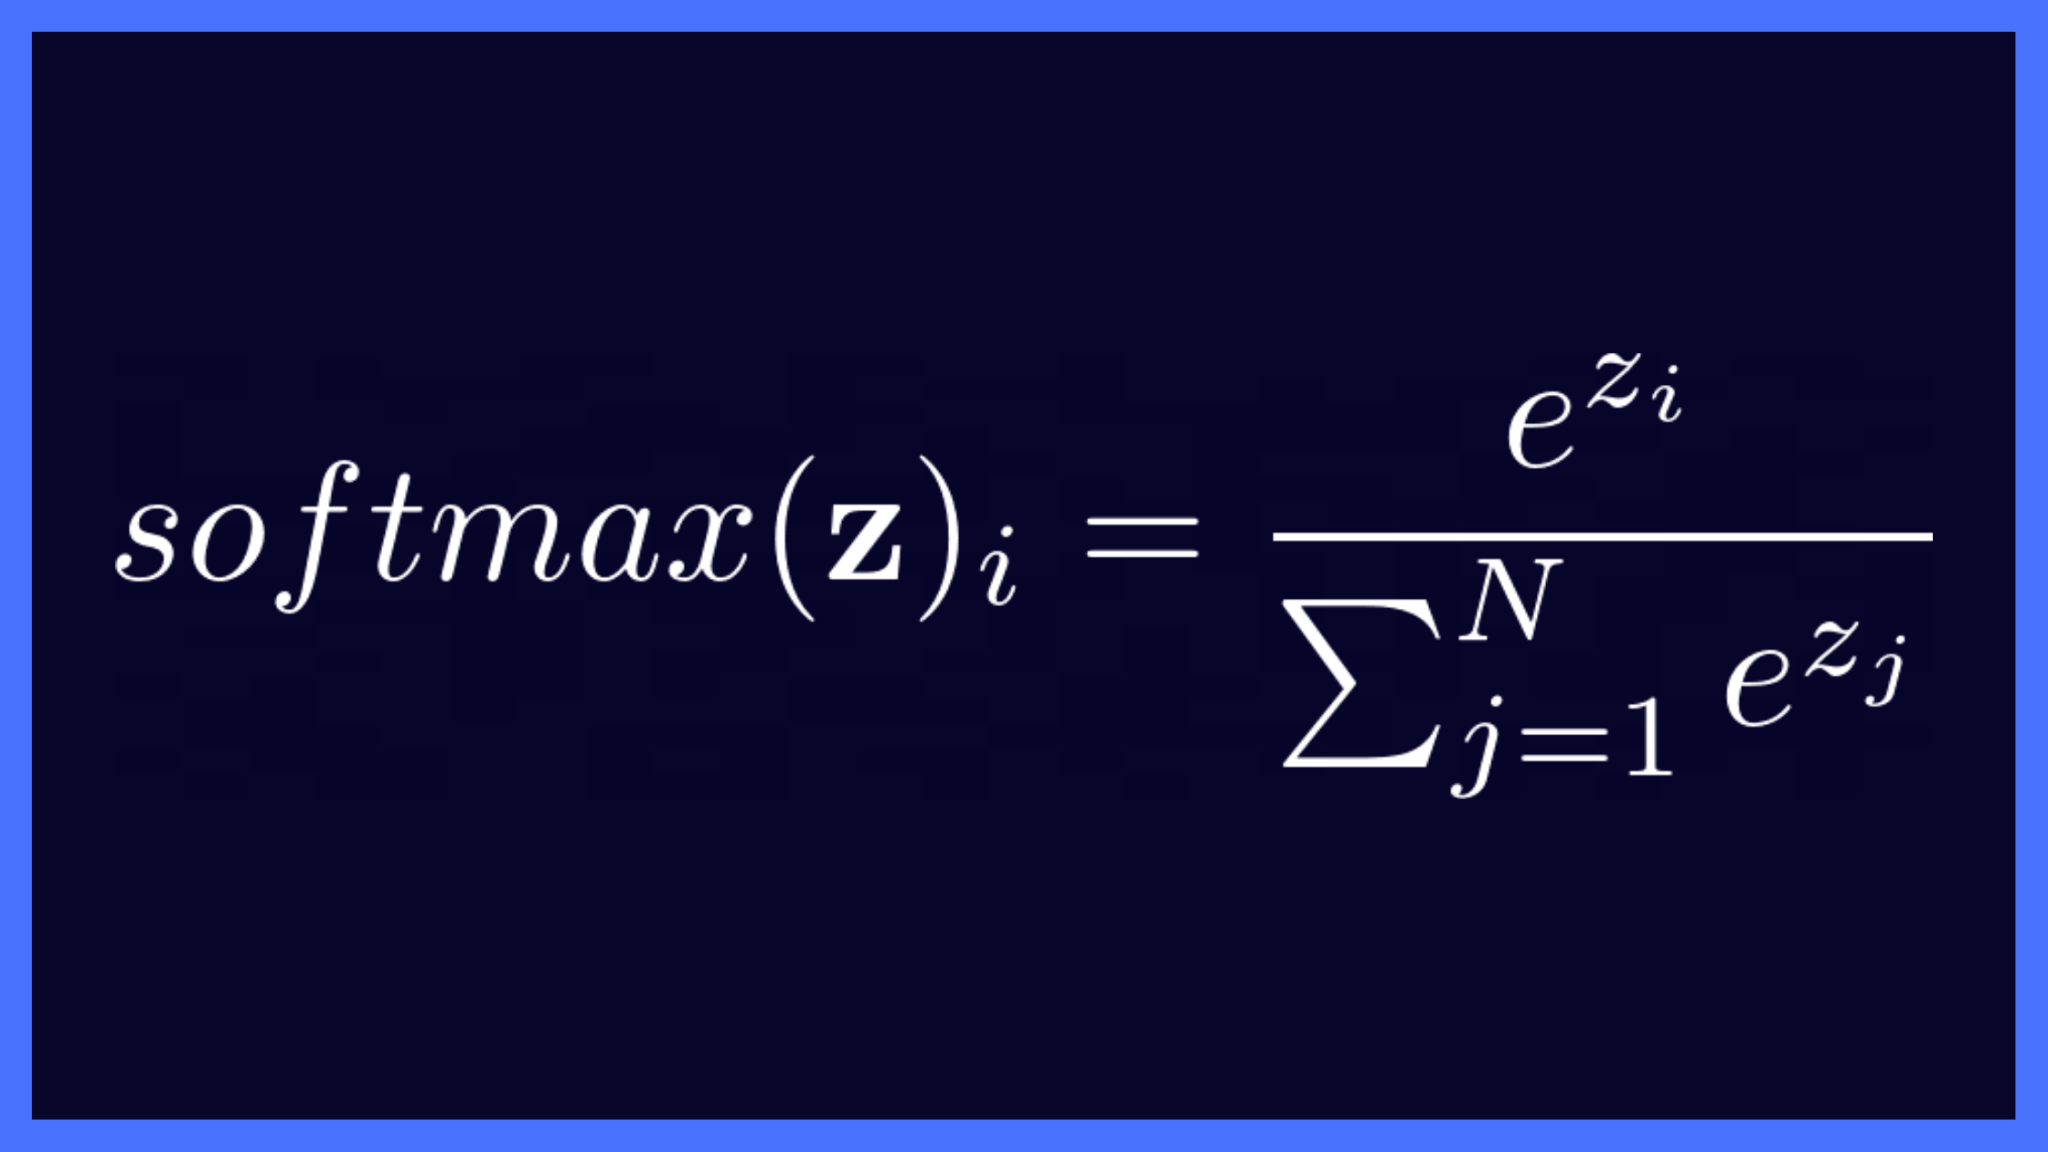

In [ ]:
counts= logits.exp()

In [ ]:
prob = counts/counts.sum(1, keepdims= True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
#every row of prob sums to 1
prob[0].sum()

tensor(1.0000)

In [ ]:
#next, same as prev
prob[torch.arange(32),Y]

tensor([2.7659e-14, 2.5304e-06, 1.4059e-03, 1.7147e-11, 4.1079e-06, 9.6156e-01,
        3.8831e-08, 9.8682e-01, 1.7202e-07, 4.7989e-10, 2.3249e-11, 3.2396e-10,
        3.6238e-10, 1.3171e-12, 1.8759e-03, 2.8238e-01, 2.1082e-03, 1.8194e-07,
        1.9762e-09, 2.4408e-03, 6.6842e-08, 7.8663e-12, 8.9172e-04, 6.5586e-02,
        7.1407e-02, 4.0707e-04, 9.8317e-04, 1.5103e-12, 4.2173e-12, 9.9236e-01,
        8.4328e-09, 5.6674e-12])

This gives the probs given by the first random setting of weights, to the correct char in the sequence. Ideally all of these numbers should be 1

In [ ]:
(prob[torch.arange(32),Y]).shape

torch.Size([32])

Now, just as before, we want the log prob's avg

In [ ]:
loss= -(prob[torch.arange(32),Y]).log().mean()
loss

tensor(19.4593)

In [ ]:
 #----------respectable version-------------

In [ ]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) #final layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3697

In [ ]:
for p in parameters:
  p.requires_grad = True


In [ ]:
for i in range(1000):
  #fwd pass
  emb= C[X]
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y) #it takes (input, target)

  #backward pass
  for p in parameters:
      p.grad = None #resetting it to 0
  loss.backward()

  #update
  for p in parameters:
      p.data += -0.1 * p.grad

print(loss.item( ))

0.2552211880683899


We're just doing it for the first 5 words still btw, so we have 3700 params for 32 inputs, so we're overfitting, thats why our loss is so low

In [ ]:
'''
these three lines:

counts= logits.exp()
prob = counts/counts.sum(1, keepdims= True)
loss= -(prob[torch.arange(32),Y]).log().mean()

~can~ SHOULD be done with the torch.cross_entropy

loss = F.cross_entropy(logits, Y)

because too high positive nums, like 100, when you do e^100 can make it go to inf but
torch handles it by -100

'''

'\nthese three lines:\n\ncounts= logits.exp()\nprob = counts/counts.sum(1, keepdims= True)\nloss= -(prob[torch.arange(32),Y]).log().mean()\n\n~can~ SHOULD be done with the torch.cross_entropy \n\nbecause too high positive nums, like 100, when you do e^100 can make it go to inf but \ntorch handles it by -100\n\n'

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([13.4871, 18.1044, 20.7258, 20.8151, 16.9594, 13.4871, 16.1917, 14.3670,
        16.0963, 18.6382, 16.1848, 21.1582, 13.4871, 17.3894, 17.3903, 20.3210,
        13.4871, 16.6965, 15.4115, 17.3172, 18.7858, 16.2183, 11.0970, 10.8827,
        15.6575, 13.4871, 16.4268, 17.1676, 12.8921, 16.3777, 19.3421, 16.3297],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Here few of them dont match, eg: the first one (9 and 1, but the 2nd one 13-13 matches), because ... is supposed to predict e for emily, but its also supposed to be o for olivia

Thats why we are not able to overfit completely and make the loss 0

I usually forget to:
* encode before i input to nn
* act funcn for hidden layer
* in backward, before loss.backward(), to make p.grad None

In [ ]:
#-----------Full dataset--------------

In [ ]:
block_size=3 #context length
X, Y= [], []
for w in words:

  # NO print(w)
  context= [0]*block_size #so context becomes [0, 0, 0]
  for ch in w + ".":
    ix= stoi[ch] #ix is the index value of the ch

    X.append(context) #current running context X

    Y.append(ix) #current char Y
    #NO print("".join(itos[i] for i in context), "--->", itos[ix])
    context= context[1:] + [ix] #crop and append


X= torch.tensor(X)
Y= torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) #final layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for i in range(10):
  #fwd pass
  emb= C[X]
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(loss.item( ))

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  for p in parameters:
      p.data += -0.1 * p.grad


19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906


In [ ]:
#this is actually inefficient

In practice, the forward pass, backward and update is done in mini batches

how?
* take 32 randint from 0 to X.shape[0] : called ix
* put in C[X[ix]] and Y[ix]

In [ ]:
torch.randint(0, X.shape[0], [32,])
#            low.    high.    size
# X's size is 228146, 3 so it will be 228k long
#chose from 0 to 228,146 and give me 32 values (pass 32 in a list )
#our batch-size is 32

tensor([  5485, 177140, 128172, 180283, 159186,  37261,   2696,  39156, 133961,
        152810,  43861, 153935, 226044,  88054,  34731, 142200, 104966,  67500,
         69929, 136309,  38533, 110023, 167707,  37147, 161444, 195849,  90731,
        126242, 160842, 190766, 135190,  35096])

In [ ]:
X.shape[0]

228146

In [ ]:
#adding in our code
for i in range(1000):

  #mini batch construct, chosing index
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] #this will again be 32,3,2 not 228, 146
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also


  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  for p in parameters:
      p.data += -0.1 * p.grad

print(loss.item( ))


2.581371545791626


because we're doing mini batches, the quaity of our gradient as not as good

So here, we have an approx gradient, but we make more steps

In [ ]:
#for full, not batchwise, full gives us real loss, the batchwise gives noisy loss
emb= C[X]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7156, grad_fn=<NllLossBackward0>)

In [ ]:
#----finding a good learning rate-----

In [ ]:
#trying with learning rate 0.001
for i in range(100):

  #mini batch construct
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] # (32, 3, 2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also
  print(loss.item( ))

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  for p in parameters:
      p.data += -0.001 * p.grad

2.718153238296509
2.8756940364837646
2.551957607269287
2.3390839099884033
2.959913969039917
2.549811601638794
2.5768914222717285
2.872847557067871
2.6209959983825684
2.7128946781158447
2.908977746963501
2.7656872272491455
2.75762939453125
2.5322418212890625
2.577723264694214
2.962108612060547
2.565061092376709
2.4903907775878906
2.779188632965088
2.5745763778686523
2.7662293910980225
2.533496618270874
2.9084091186523438
2.951822280883789
2.590363025665283
2.4825026988983154
2.8314805030822754
2.47098970413208
2.6166582107543945
2.4676239490509033
2.672140598297119
3.1298162937164307
2.525535821914673
3.268592357635498
2.6137681007385254
2.889066219329834
2.638237714767456
2.5764899253845215
2.480825424194336
3.2737863063812256
2.7555148601531982
2.702587842941284
2.934321880340576
2.5504636764526367
2.3610188961029053
2.49187970161438
2.6779370307922363
2.0677075386047363
2.846264123916626
2.2304582595825195
2.574510097503662
3.087646961212158
2.4841551780700684
2.7342073917388916
2.73

That was too slow

In [ ]:
#trying with learning rate 1
for i in range(100):

  #mini batch construct
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] # (32, 3, 2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also
  print(loss.item( ))

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  for p in parameters:
      p.data += -1 * p.grad

2.9623398780822754
7.498434066772461
11.81010913848877
10.995838165283203
11.095647811889648
12.076380729675293
9.490219116210938
8.789363861083984
11.962181091308594
8.736976623535156
9.128711700439453
9.63190746307373
8.719757080078125
7.458996295928955
9.13054370880127
6.437074661254883
7.883279800415039
9.724552154541016
8.975617408752441
11.43698787689209
8.59315013885498
7.740127086639404
7.40395975112915
10.302974700927734
9.576220512390137
7.432365894317627
8.730497360229492
7.409152984619141
7.3014421463012695
7.890884876251221
7.510580062866211
8.973319053649902
9.959102630615234
8.47775936126709
10.175924301147461
10.101943969726562
7.30997371673584
9.550999641418457
7.516027450561523
6.8437042236328125
7.578005790710449
8.894283294677734
9.401586532592773
7.645272254943848
7.923085689544678
5.8932785987854
6.7527899742126465
6.108119487762451
5.878727912902832
8.384416580200195
6.81611967086792
6.32297945022583
4.624145984649658
5.766116142272949
6.363568305969238
6.8375573

slighly high, but OK

In [ ]:
#trying with learning rate 10 NO WAY
for i in range(10):

  #mini batch construct
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] # (32, 3, 2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also
  print(loss.item( ))

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  for p in parameters:
      p.data += -10 * p.grad

19.382665634155273
49.69551467895508
61.23114013671875
81.5224609375
63.59571838378906
93.14114379882812
79.42787170410156
72.00615692138672
89.19448852539062
86.28681945800781


So, lets search for a good learning rate between 0.001 and 1, but lets search non-linearly

In [ ]:
#learning rate exponent
lre=torch.linspace(-3,0,1000) #coz, 0.001 is 10^-3 and 1 is 10^0
lrs= 10**lre

In [ ]:
 #---again----

In [ ]:
block_size=3 #context length
X, Y= [], []
for w in words:

  # NO print(w)
  context= [0]*block_size #so context becomes [0, 0, 0]
  for ch in w + ".":
    ix= stoi[ch] #ix is the index value of the ch

    X.append(context) #current running context X

    Y.append(ix) #current char Y
    #NO print("".join(itos[i] for i in context), "--->", itos[ix])
    context= context[1:] + [ix] #crop and append


X= torch.tensor(X)
Y= torch.tensor(Y)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) #final layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
#lr used
lri = []
lossi = [] #losses

for i in range(1000):

  #mini batch construct
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] # (32,3,2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  lr= lrs[i]
  for p in parameters:
      p.data += -lr * p.grad

  #track stats
  lri.append(lre[i])
  lossi.append(loss.item())

learning rates vs loss,
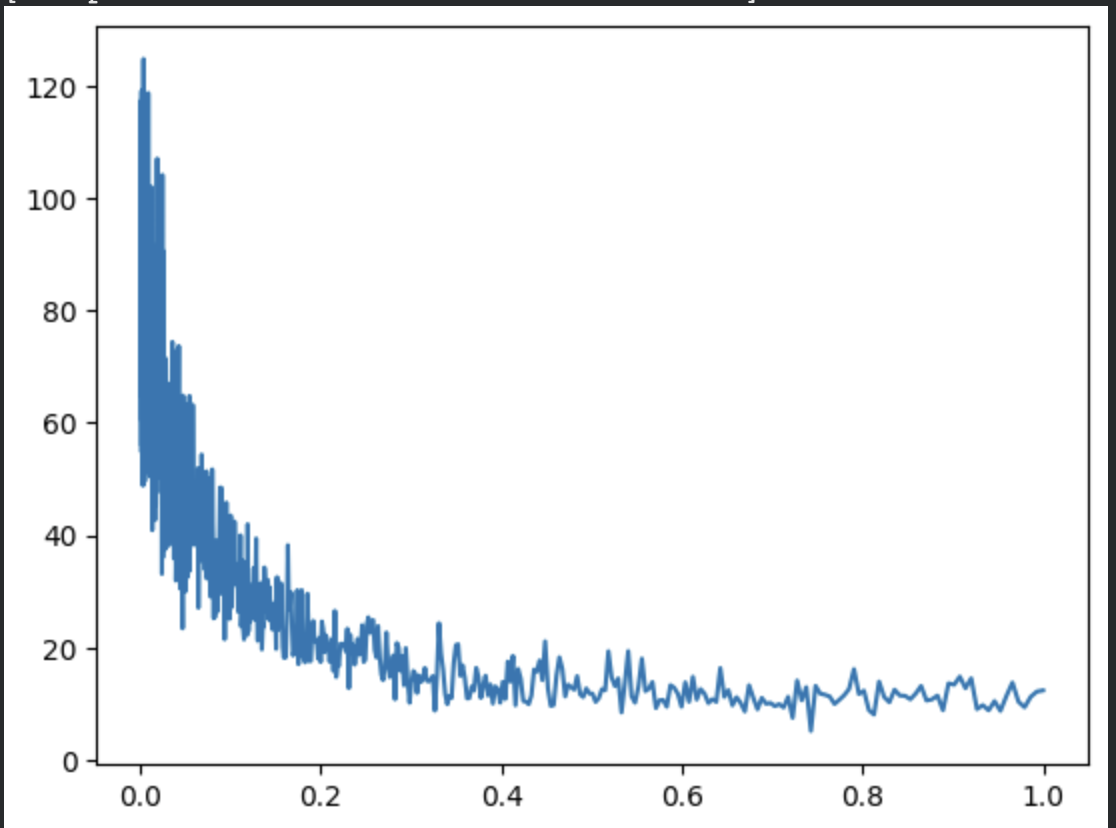

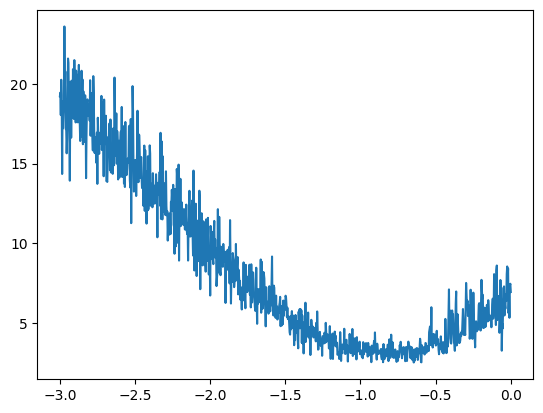

In [ ]:
#plotting exp of learning rate vs losses
plt.plot(lri, lossi)

So -1 gives pretty good, so 10^-1 is 0.1, so 0.1 learning was pretty good

In [ ]:
#lr used
lri = []
lossi = [] #losses

for i in range(10000):

  #mini batch construct
  ix= torch.randint(0, X.shape[0], [32,])

  #fwd pass
  emb= C[X[ix]] # (32,3,2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) #not just X, Y also

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  #lr= lrs[i]
  lr=0.1
  for p in parameters:
      p.data += -lr * p.grad

  #track stats
  #lri.append(lre[i])
  #lossi.append(loss.item())

In [ ]:
#for full, not batchwise
emb= C[X]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3742, grad_fn=<NllLossBackward0>)

To avoid overfitting we split our dataset

In [ ]:
# training split (80%) | dev/validation split (10%) | test split (10%)

80% will be used to optimize the parameters of the model

dev/val 10% will be used for develpment of all the hyper-parameters

test split will evaluate performace

how?
* make a build_dataset function which takes words as arg, it returns X, Y
* randomly shuffle the dataset
* make n1 an int of len of 80% of dataset, and n2 of 90%
* build_dataset upto len n1 -> X train, Y train
* build_dataset from len n1 to n2 -> X dev, Y dev
* build_dataset from n2 to full -> X test, Y test
* fwd pass on train (replace X with Xtr, Y with Ytr)
* while calculating full loss, do with Xdev, Ydev
* finally do full with Xte, Yte once

In [ ]:
#build the dataset

def build_dataset(words):
  block_size=3 #context length,
  X, Y= [], []
  for w in words:

    #print(w)
    context= [0]*block_size
    for ch in w + ".":
      ix= stoi[ch] #ix is the index value of the ch

      X.append(context) #current running context X

      Y.append(ix) #current char Y
      #print("".join(itos[i] for i in context), "--->", itos[ix])
      context= context[1:] + [ix] #crop and append

  X= torch.tensor(X)
  Y= torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

#randomly shuffle the words
import random
random.shuffle(words)
#n1 is 80% of the words
n1 = int( 0.8 * len(words))
#n2 is 90%
n2 = int( 0.9 *len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182615, 3]) torch.Size([182615])
torch.Size([22704, 3]) torch.Size([22704])
torch.Size([22827, 3]) torch.Size([22827])


In [ ]:
n1 #we have 25k words for training

25626

In [ ]:
n2

28829

In [ ]:
n2-n1 #we have 3k examples for dev

3203

In [ ]:
len(words)-n2 #for the test we have 3204 words

3204

In [ ]:
#dataset for training

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182615, 3]), torch.Size([182615]))

In [ ]:
#reset network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) #final layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
#change X to Xtr, Y to Ytr
lri = []
lossi = [] #losses

for i in range(30000):

  #mini batch construct
  ix= torch.randint(0, Xtr.shape[0], [32,])

  #fwd pass
  emb= C[Xtr[ix]] # (32,3,2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix]) #not just Xtr, Ytr also

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  lr= 0.1
  for p in parameters:
      p.data += -lr * p.grad



In [ ]:
print(loss.item())

2.3937630653381348


In [ ]:
#using dev
#for full, not batchwise
emb= C[Xdev]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3623, grad_fn=<NllLossBackward0>)

In [ ]:
#using train
#for full, not batchwise
emb= C[Xtr]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3554, grad_fn=<NllLossBackward0>)

so dev and training loss are aprox the same, so we are NOT overfitting rather we are

UNDERfitting

our network is very tiny, so we need to

INCREASE the size of the neural net

In [ ]:
#build the dataset again (same code)

def build_dataset(words):
  block_size=3 #context length,
  X, Y= [], []
  for w in words:

    #print(w)
    context= [0]*block_size
    for ch in w + ".":
      ix= stoi[ch] #ix is the index value of the ch

      X.append(context) #current running context X

      Y.append(ix) #current char Y
      #print("".join(itos[i] for i in context), "--->", itos[ix])
      context= context[1:] + [ix] #crop and append

  X= torch.tensor(X)
  Y= torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

#randomly shuffle the words
import random
random.shuffle(words)
#n1 is 80% of the words
n1= int(0.8*len(words))
#n2 is 90%
n2= int(0.9*len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182594, 3]) torch.Size([182594])
torch.Size([22744, 3]) torch.Size([22744])
torch.Size([22808, 3]) torch.Size([22808])


In [ ]:
#reset network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) #up to 300
b1 = torch.randn(300, generator=g) #300
W2 = torch.randn((300, 27), generator=g) #final layer, 300
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

We have 10k instead of 3k params now

In [ ]:
#change X to Xtr, Y to Ytr
lri = []
lossi = [] #losses
stepi = [] #lets keep track of steps also now

for i in range(30000):

  #mini batch construct
  ix= torch.randint(0, Xtr.shape[0], [32,])

  #fwd pass
  emb= C[Xtr[ix]] # (32,3,2)
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix]) #not just Xtr, Ytr also

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  lr= 0.1
  for p in parameters:
      p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.item())

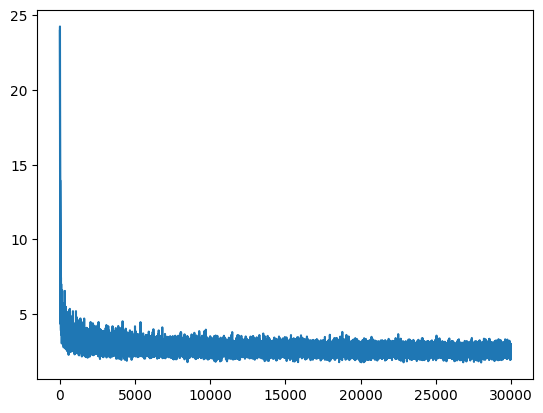

In [ ]:
plt.plot(stepi, lossi)

The loss at the bottom is because of the batches

In [ ]:
#using dev
#for full, not batchwise
emb= C[Xdev]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3145, grad_fn=<NllLossBackward0>)

In [ ]:
#using train
#for full, not batchwise
emb= C[Xtr]
h= torch.tanh(emb.view(-1,6) @ W1 + b1) #32,100
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2923, grad_fn=<NllLossBackward0>)

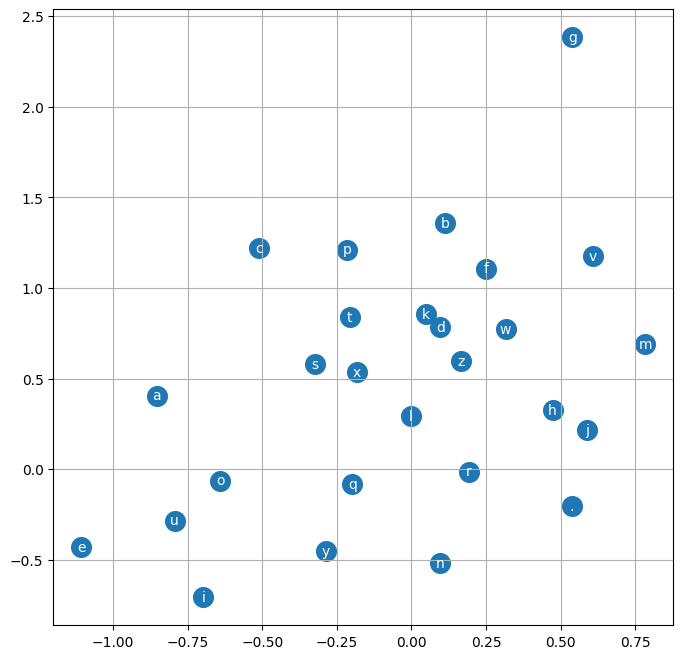

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Here, we can see that the vowels are grouped together (btm left)

Now, we have made the hidden layer, much larger, but the losses have not gone down a lot, so the bottleneck must be that we are putting everything intoa 2D space, so we will use a higher dim space, but we wont be able to "See" anymore

In [ ]:
#reset network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) #10 instead of 2
W1 = torch.randn((3*10, 200), generator=g) #down to 200
b1 = torch.randn(200, generator=g) #300
W2 = torch.randn((200, 27), generator=g) #final layer, 200
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
lri = []
lossi = [] #losses
stepi = [] #lets keep track of steps also now

In [ ]:
for i in range(50000):

  #mini batch construct
  ix= torch.randint(0, Xtr.shape[0], [32,])

  #fwd pass
  emb= C[Xtr[ix]] # (32,3,2)
  h= torch.tanh(emb.view(-1,30) @ W1 + b1) #30 instead of 6
  logits= h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix]) #not just Xtr, Ytr also

  #backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  #update
  lr= 0.01
  for p in parameters:
      p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10() .item())

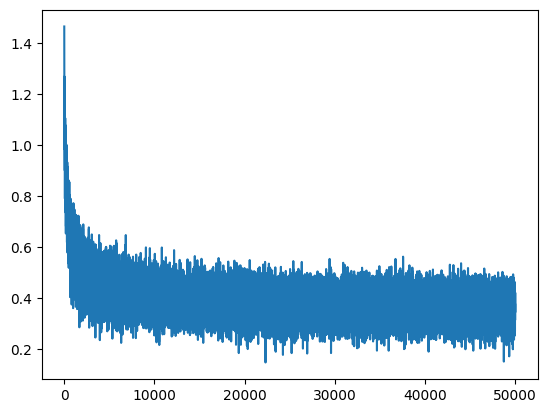

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
#using dev
#for full, not batchwise
emb= C[Xdev]
h= torch.tanh(emb.view(-1,30) @ W1 + b1) #30 not 6
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1969, grad_fn=<NllLossBackward0>)

In [ ]:
#using train
#for full, not batchwise
emb= C[Xtr]
h= torch.tanh(emb.view(-1,30) @ W1 + b1) #30 not 6
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1585, grad_fn=<NllLossBackward0>)

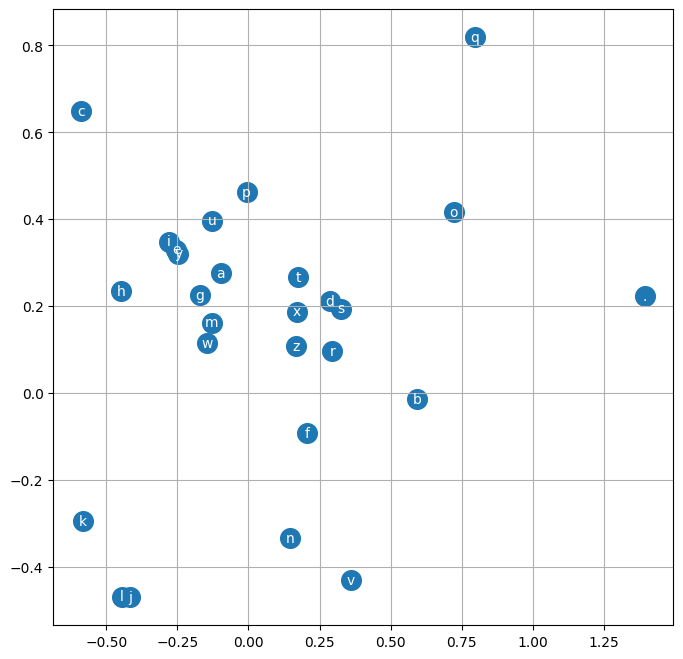

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Now, we can do this again or we can change the parameters-
1. Add more layers
2. Take more than 3 chars

In [ ]:
 #-----slight change------ FULL

 # the change is addn of learning rate decay and more epochs + sampling

In [ ]:
#preliminaries

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words= open("/content/names.txt", "r").read().splitlines()
print(words[:8])

#build vocabulary and map, from words (as char) to string and vice versa
chars=sorted(list(set("".join(words))))# a b c...z
stoi= {s:i+1 for i,s in enumerate(chars)}
stoi["."]=0
itos= {i:s for s,i in stoi.items()}
print(f"{itos=}")
print(f"{stoi=}")

In [ ]:
#build the dataset again (same code)

def build_dataset(words):
  block_size=3 #context length,
  X, Y= [], []
  for w in words:

    #print(w)
    context= [0]*block_size
    for ch in w + ".":
      ix= stoi[ch] #ix is the index value of the ch

      X.append(context) #current running context X

      Y.append(ix) #current char Y
      #print("".join(itos[i] for i in context), "--->", itos[ix])
      context= context[1:] + [ix] #crop and append

  X= torch.tensor(X)
  Y= torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

#randomly shuffle the words
import random
random.shuffle(words)
#n1 is 80% of the words
n1= int(0.8*len(words))
#n2 is 90%
n2= int(0.9*len(words))

Xtr, Ytr= build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
#reset network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) #10 instead of 2
W1 = torch.randn((3*10, 200), generator=g) #down to 200
b1 = torch.randn(200, generator=g) #300
W2 = torch.randn((200, 27), generator=g) #final layer, 200
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
lri = []
lossi = [] #losses
stepi = [] #steps

In [ ]:
for i in range(200000): #200k epochs

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 #lr of 0.1 first half, 0.01 next half
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

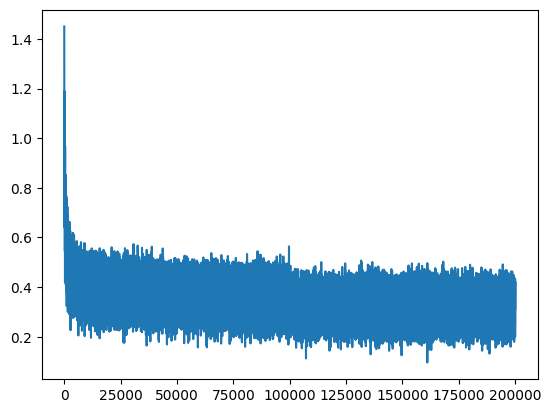

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
#using dev
#for full, not batchwise
emb= C[Xdev]
h= torch.tanh(emb.view(-1,30) @ W1 + b1) #30 not 6
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1762, grad_fn=<NllLossBackward0>)

In [ ]:
#using train
#for full, not batchwise
emb= C[Xtr]
h= torch.tanh(emb.view(-1,30) @ W1 + b1) #30 not 6
logits= h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1264, grad_fn=<NllLossBackward0>)

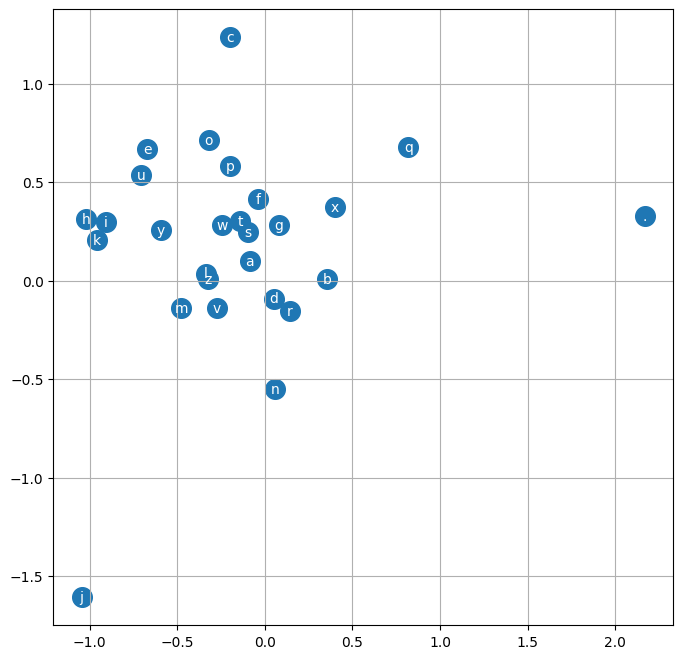

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3 #context length,

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carpah.
amoriq.
khy.
mili.
thilahnanden.
jazon.
nammerystingeli.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinn.
sulin.
alianni.
waterri.
jarynix.
kaellinsleen.
deci.
abetteley.


In [ ]:
#More name like
#so the nn
'''
[ 228,146 (after emb) -> 100  -> 27 ]  -> 1
        first          hidden   logits  softmax
'''